<a href="https://colab.research.google.com/github/makrez/BioinformaticsTools/blob/master/16S_Convolutional_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Introduction**



## 16S classification of DNA sequences

This notebook showcases an attempt to cluster bacterial 16S sequences using
a convolutional classifier.

### Background

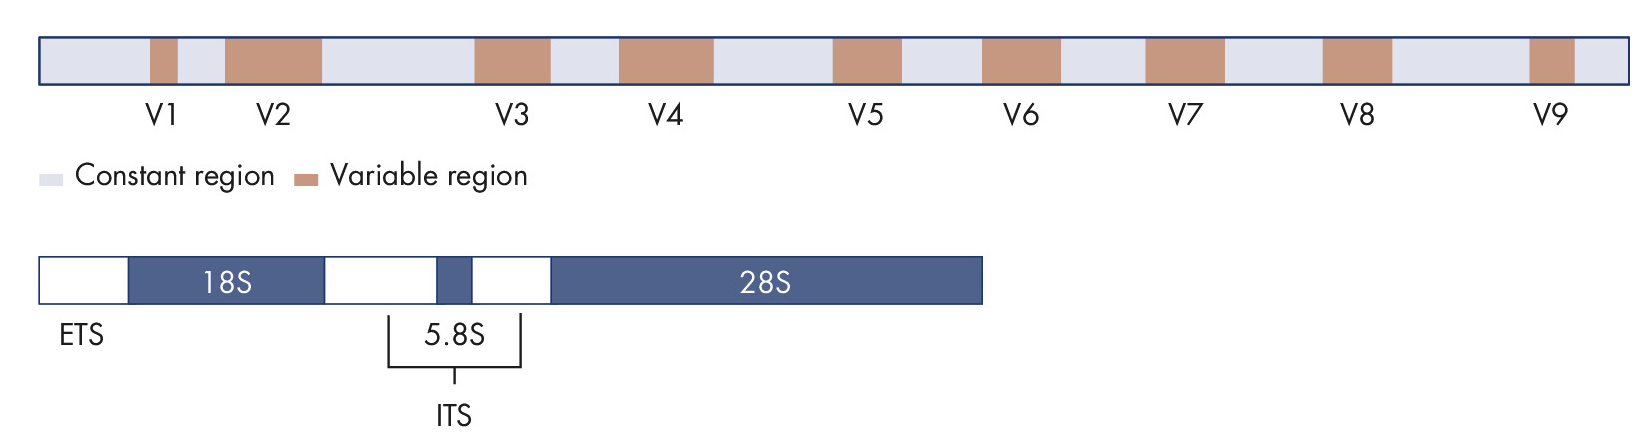


The 16S region is widely used to classify/identify microbial
taxa.

### DNA data preparation

1. The 16S DNA sequences had to be downloaded from a suitable database. Here, the SILVA database (v.138.1) was use,see [here](https://www.arb-silva.de/download/archive/). 

2. A suitable taxon lineage had to be chosen. In this notebook, we chose taxa from genus Bacillus.

3. The 16S sequences were aligned:


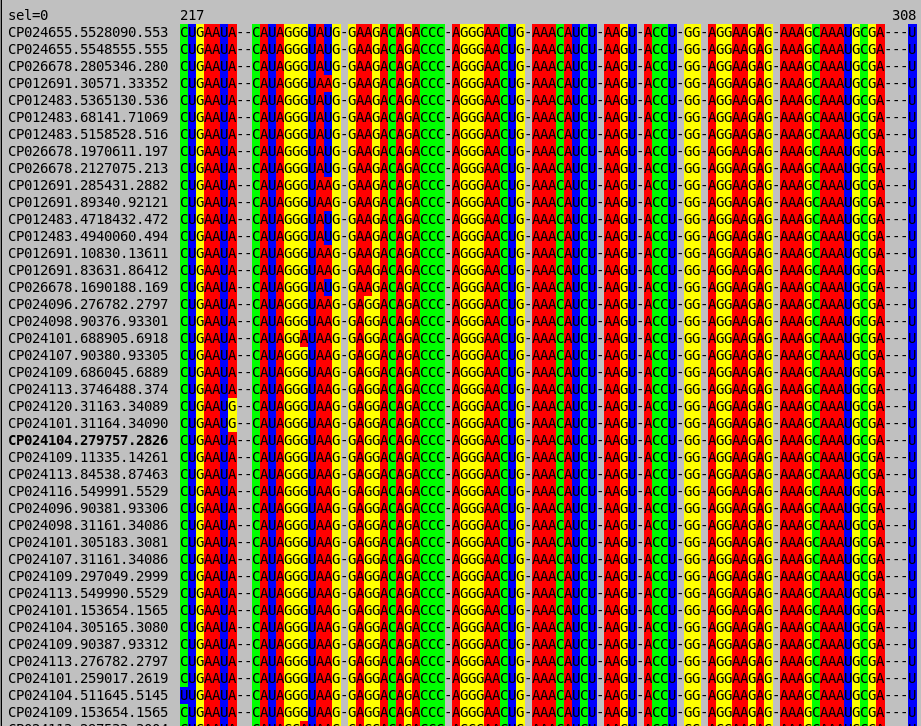



# Data preparation

In [1]:
import re
import os
!pip install biopython
from Bio import SeqIO
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following code snippet gives an overview of the alignment.

In [ ]:
from Bio import AlignIO
from collections import Counter

def summarize_msa(file_path, num_lines_to_display=5):
    alignment = AlignIO.read(file_path, 'fasta')
    num_sequences = len(alignment)
    alignment_length = alignment.get_alignment_length()

    # Count occurrences of each base and gaps
    counts = Counter()
    total_bases = num_sequences * alignment_length
    for record in alignment:
        counts.update(record.seq)
        
    # Calculate the percentages
    percentages = {base: (count / total_bases) * 100 for base, count in counts.items()}

    print(f"Number of sequences: {num_sequences}")
    print(f"Alignment length: {alignment_length}")
    print("\nPercentages of bases and gaps:")
    for base, percentage in percentages.items():
        if percentage > 0:
            print(f"{base}: {percentage:.2f}%")
    
    print("\nFirst few lines of the alignment:")
    for idx, record in enumerate(alignment):
        if idx < num_lines_to_display:
             print(f"{record.id}: {str(record.seq)[:100]}")
        else:
            break

# Read and summarize the MSA
msa_file_path = '/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln'
summarize_msa(msa_file_path)



Number of sequences: 2626
Alignment length: 4559

Percentages of bases and gaps:
-: 35.89%
c: 14.05%
g: 19.88%
u: 12.92%
a: 17.25%
y: 0.00%
n: 0.00%
r: 0.00%
v: 0.00%
w: 0.00%
m: 0.00%
s: 0.00%
k: 0.00%

First few lines of the alignment:
CP013727.2895443.2898376: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacg
CP013727.3739212.3742145: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacg
CP013727.2977038.2979971: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacg
CP013727.2917179.2920112: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacg
CP013727.3059769.3062702: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacg


### Class for One Hot Encoding

DNA is usually represented with four letters. In the context of a convolutional operation, we have to transform the DNA into a 1d tensor with 6 channels. The 6 channels contain the four nucleatides, gaps and Ns (which repesent non-identified bases).


In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        # Fill missing channels with zeros
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded



### Read data

The data is read into two lists: One list containing the sequences and the other containing the corresponding taxonomic labels.

In [ ]:
flatted_sequence = list()
sequence_labels = list()

alignment_length = 1500

with open('/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    label = str(record.description).rsplit(';', 1)[-1]
    seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
    
    if len(seq_hot) == alignment_length:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)

## Convolutional Classifier

Here, a convolutional classifier is defined. The main idea is to have a few layers that use convolutional and pooling layers to learn a representation of the input sequence and to then pass this on to fully connected layers.


In [14]:
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Define the model

class ConvClassifier(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ConvClassifier, self).__init__()
        self.input_length = input_length
        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
        )

        # Calculate the size of the final feature map after convolutional and pooling layers
        feature_map_size = input_length // (2 * 2 * 2)

        # Define the classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(64 * feature_map_size, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Change dataset to include labels

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __getitem__(self, index):
        return {
            "sequence": torch.tensor(self.sequences[index]).float(),
            "label": torch.tensor(self.labels[index]).long(),
        }

    def __len__(self):
        return len(self.sequences)

## Encode labels into integers

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sequence_labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flatted_sequence, encoded_labels, test_size=0.2, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvClassifier(input_length=alignment_length, num_classes=num_classes)
model.to(device)

print(model)



ConvClassifier(
  (features): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=11968, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
)


Epoch: 1 	Training Loss: 1.790186 	Test Loss: 1.259301
Epoch: 2 	Training Loss: 0.962142 	Test Loss: 0.669744
Epoch: 3 	Training Loss: 0.670087 	Test Loss: 0.665295
Epoch: 4 	Training Loss: 0.655298 	Test Loss: 0.637329
Epoch: 5 	Training Loss: 0.626306 	Test Loss: 0.613292
Epoch: 6 	Training Loss: 0.617155 	Test Loss: 0.615736
Epoch: 7 	Training Loss: 0.598827 	Test Loss: 0.608979
Epoch: 8 	Training Loss: 0.586045 	Test Loss: 0.570781
Epoch: 9 	Training Loss: 0.573674 	Test Loss: 0.559775
Epoch: 10 	Training Loss: 0.565486 	Test Loss: 0.554676
Epoch: 11 	Training Loss: 0.552928 	Test Loss: 0.585004
Epoch: 12 	Training Loss: 0.552370 	Test Loss: 0.531960
Epoch: 13 	Training Loss: 0.535110 	Test Loss: 0.537495
Epoch: 14 	Training Loss: 0.528043 	Test Loss: 0.515234
Epoch: 15 	Training Loss: 0.526174 	Test Loss: 0.518314
Epoch: 16 	Training Loss: 0.517118 	Test Loss: 0.527777
Epoch: 17 	Training Loss: 0.517945 	Test Loss: 0.521334
Epoch: 18 	Training Loss: 0.515107 	Test Loss: 0.511096
E

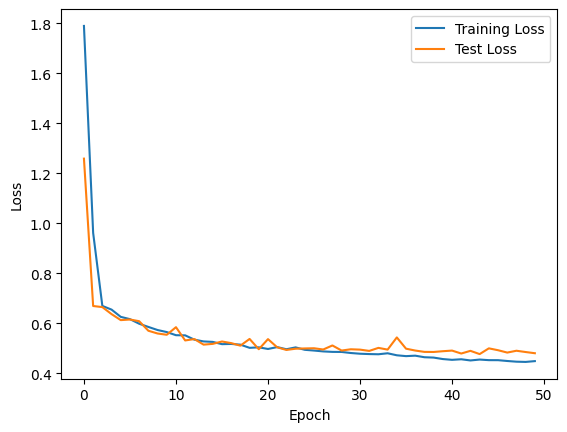

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(flatted_sequence, encoded_labels, test_size=0.2, random_state=42)

# Create separate datasets and dataloaders for training and test sets
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(np.unique(encoded_labels))

criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50

train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    # Training loop
    train_loss = 0.0
    model.train()
    for batch in train_dataloader:
        sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(sequence_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * sequence_data.size(0)

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Test loop
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
            labels = batch["label"].to(device)

            outputs = model(sequence_data)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * sequence_data.size(0)

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f}")

# Plot the training and test errors
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Create a confusion matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_dataloader:
        sequence_data = batch["sequence"].permute(0, 2, 1).float().to(device)
        labels = batch["label"].to(device)

        outputs = model(sequence_data)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

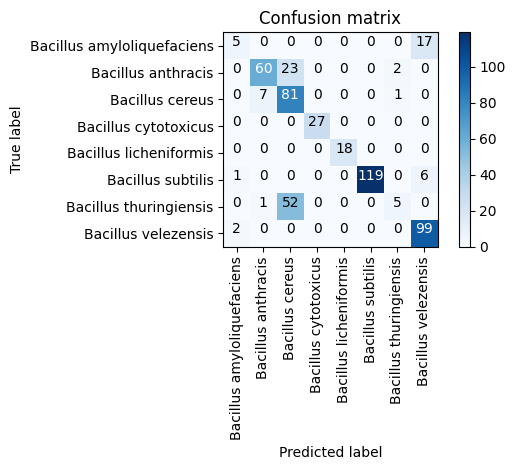

In [ ]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names)
plt.show()
